In [16]:
import pandas as pd
import numpy as np
import sys, os
from importlib import reload
import analysis_functions as f

# Append path for testing - use pyproject for the future
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..', 'src')))
import analysis_functions as f
reload(f)


<module 'analysis_functions' from 'c:\\Users\\asacco\\OneDrive - Plymouth Rock Assurance Corp\\Desktop\\repos\\analysis_tools\\src\\analysis_functions.py'>

In [2]:
df = pd.read_csv("../data/bank-full.csv", delimiter=';')

In [3]:
df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no


In [ ]:
# Convert 'y' to numeric for analysis
df["target"] = np.where(df["y"] == "no", 0, 1)

# Add weights to test weight functionality of plot_target_vs_predictors()
df["weights"] = np.abs(np.random.randn(len(df.index)))

0        1.005530
1        0.896297
2        0.491852
3        0.473130
4        1.146721
           ...   
45206    2.624969
45207    0.819605
45208    0.641620
45209    0.050524
45210    0.678397
Name: weights, Length: 45211, dtype: float64

## plot_target_vs_predictors function

In [46]:
predictors =  ["job", "balance", "contact", "duration", "marital", "job", "pdays", "previous"]

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that 

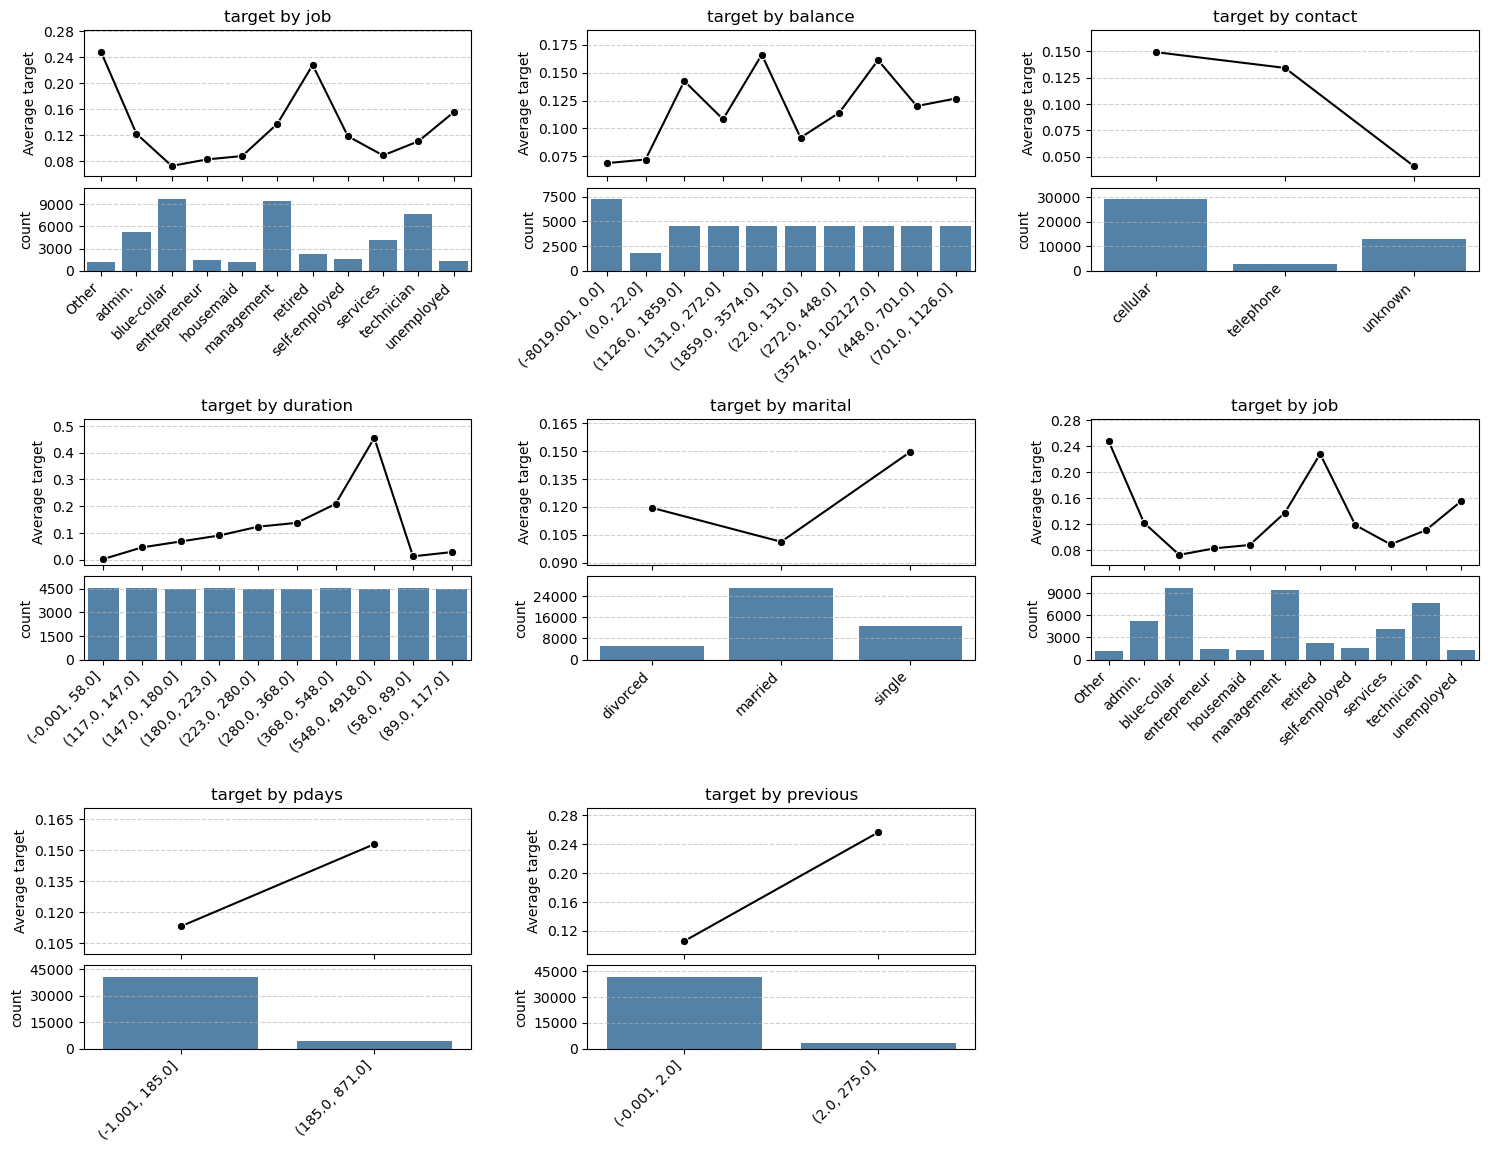

In [67]:
reload(f)
f.plot_target_vs_predictors(df, "target", predictors)

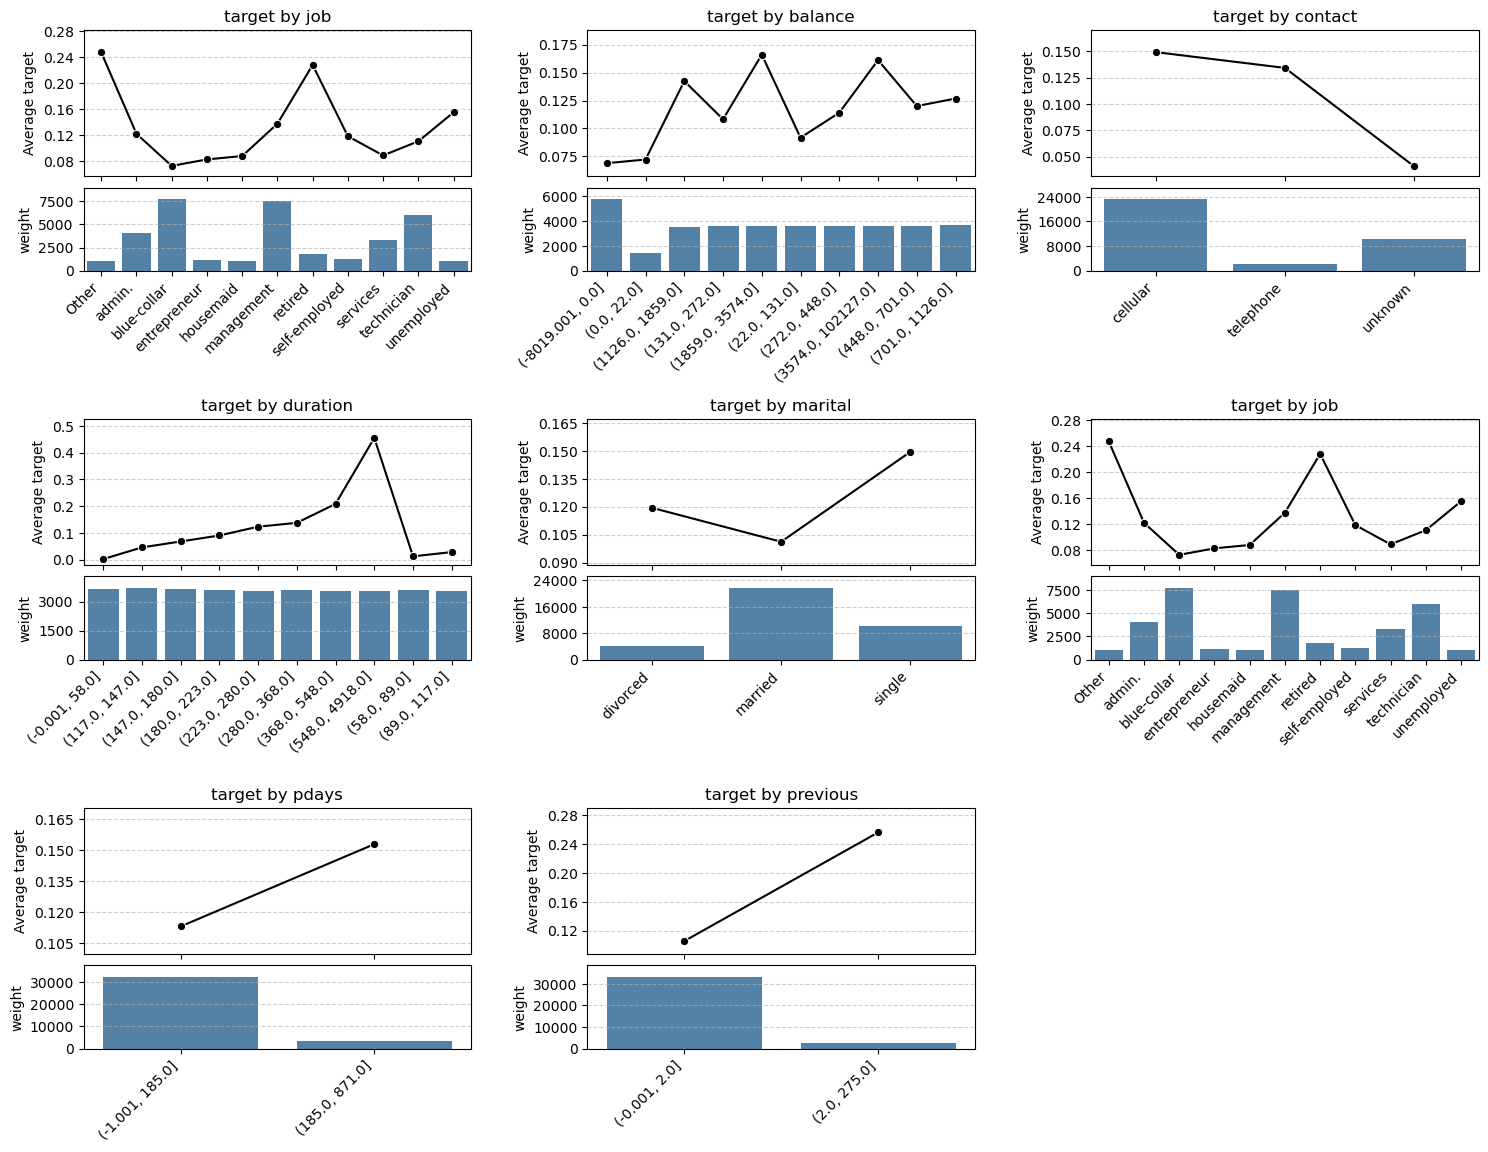

In [68]:
f.plot_target_vs_predictors(df, "target", predictors, weight_col="weights")

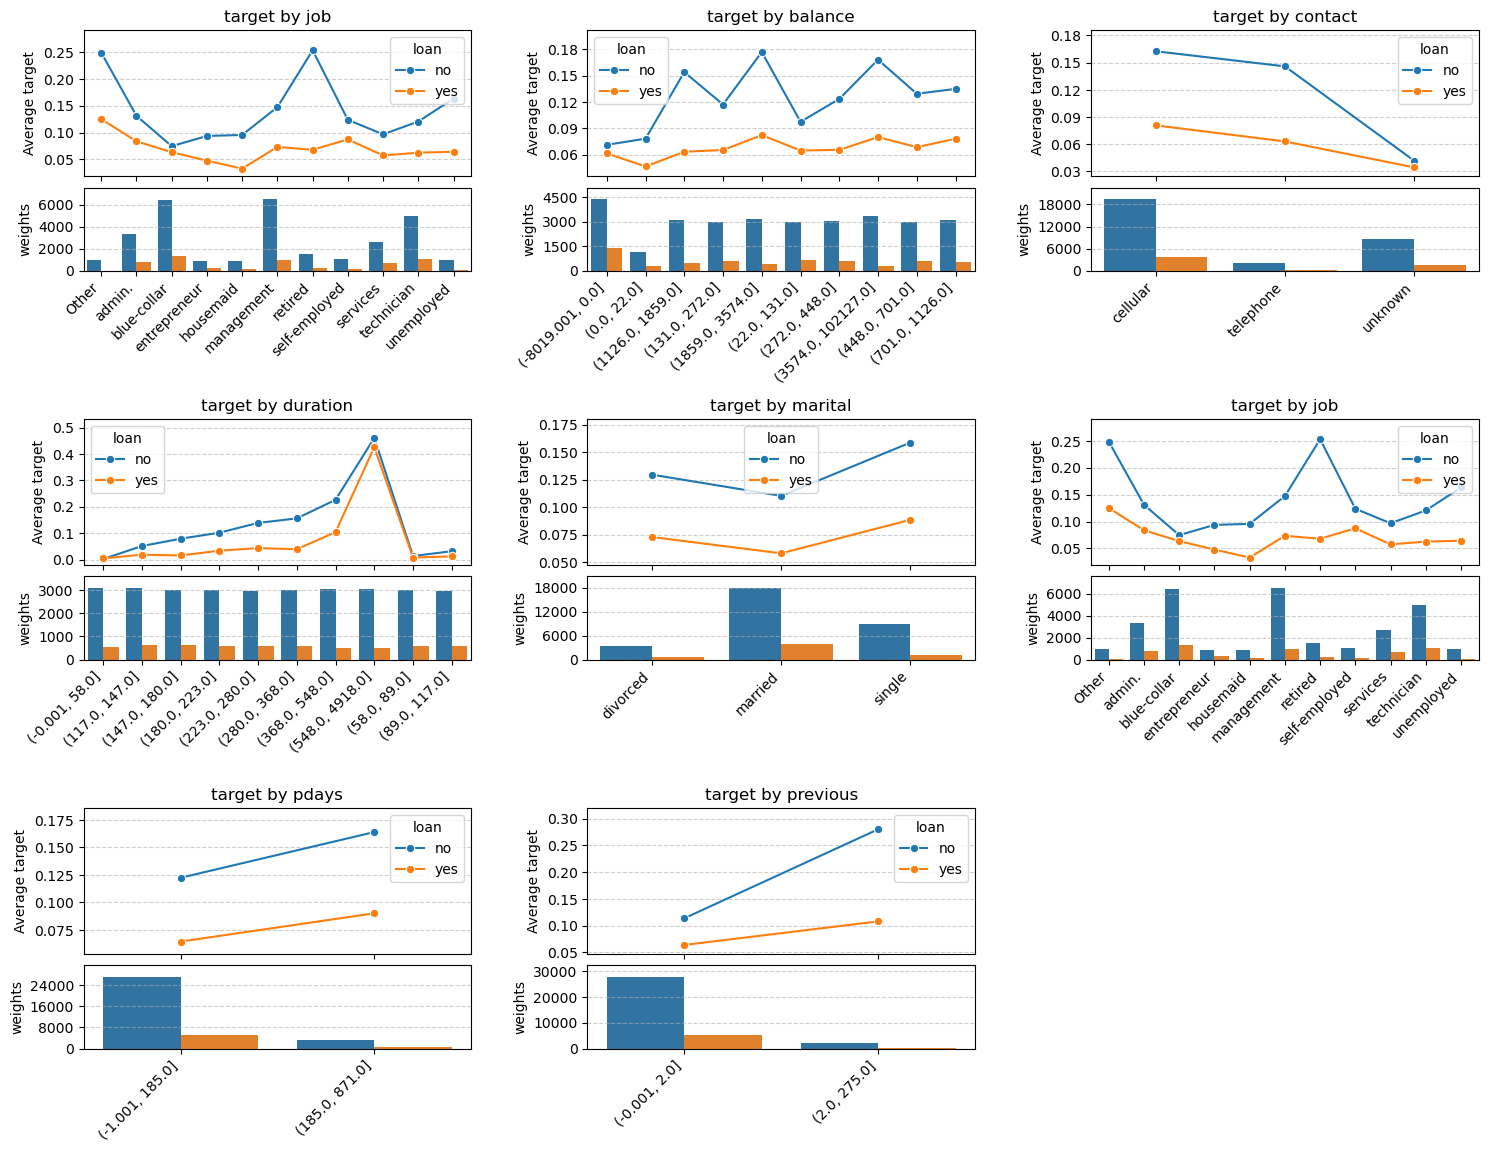

In [76]:
reload(f)
f.plot_target_vs_predictors(df, "target", predictors, group_col="loan", weight_col="weights")

## plot_variable_distributions function

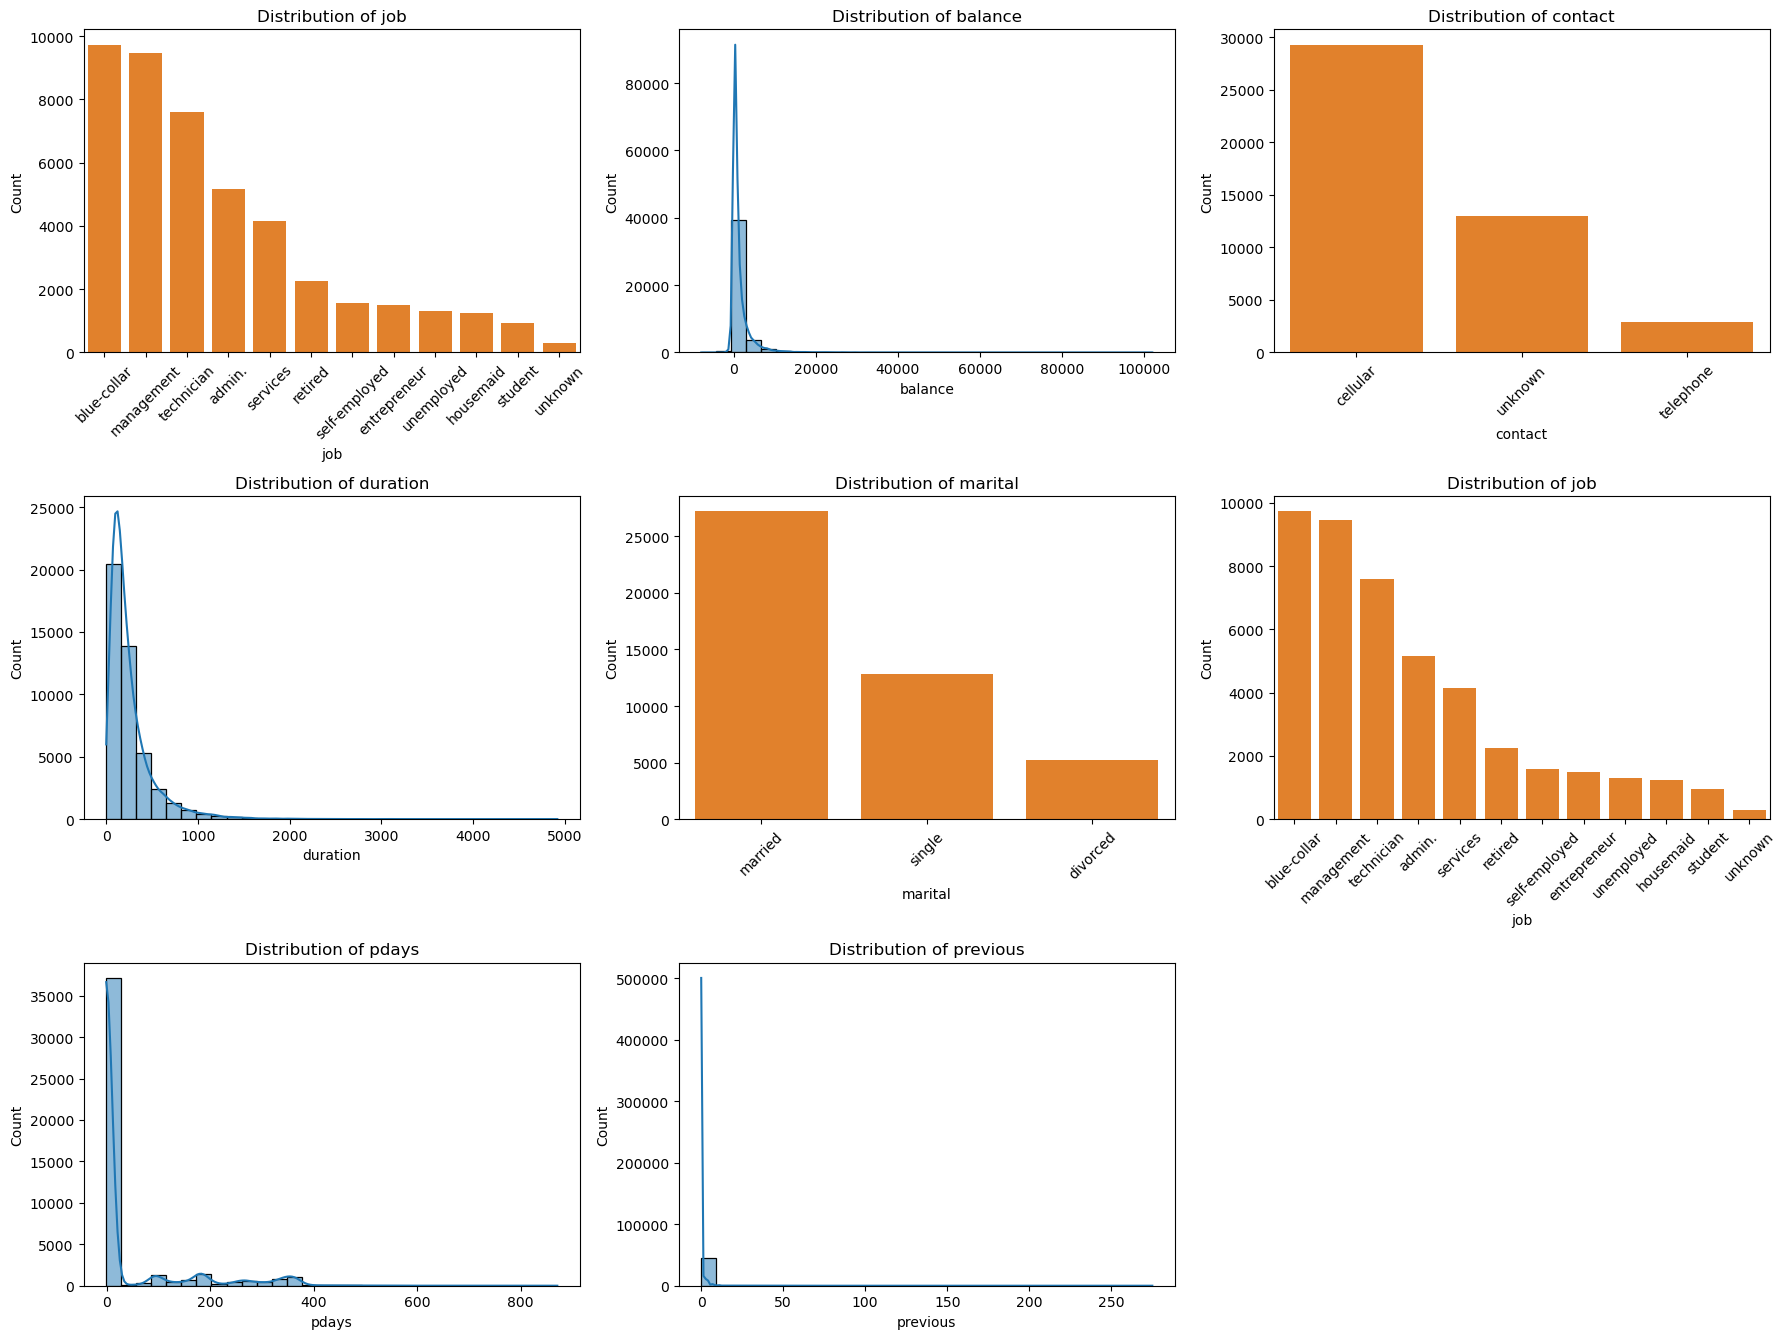

In [77]:
f.plot_variable_distributions(df, predictors, bins=30)